## Multiclass classification

Note the next cell takes around 10 mins to run!

This could be using the OvO strategy (One vs One classifier) where since there are 3 classes, it would train 3 binary classifiers and select the class which wins the most. Note that in this case, the OvR strategy (One vs Rest) was chosen by the model (can see in output). It would also need to train 3 binary classifiers so there's not much of a difference in performance. This quickly changes as we increase the number of classes!


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.svm import SVC
import random
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
# define function to get dataset, clean and simplify it and create stratified train/test
def get_train_test():
    # load
    df = pd.read_csv("star_classification.csv")
    # remove outliers
    # select the row with u or z or g below 0 (should not be allowed)
    outliers = df[(df["u"] <= 0)  
                | (df["z"] <= 0) 
                | (df["g"] <= 0)]

    # drop the row corresponding to the outlier
    df = df.drop(outliers.index, axis=0)
    # we drop the data we are not interested in and which won't be useful
    df = df.drop(
        columns=["alpha", "delta", "obj_ID", "fiber_ID", "MJD", "plate", "spec_obj_ID", 
                 "field_ID", "cam_col", "rerun_ID", "run_ID"], axis=1)
    
    # replace all infinite values with NaN
    #df = df.replace([np.inf, -np.inf], np.nan)
    #df = df.dropna(axis=0)
    
    # replace star class with 1s and others with 0
    #df.loc[df['class'] == "STAR", 'class'] = 1
    #df.loc[df['class'] != "STAR", 'class'] = 0
    
    # stratified split
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    
    for train_index, test_index in split.split(df, df["class"]):
        strat_train_set = df.loc[train_index]
        strat_test_set = df.loc[test_index]
        
    return strat_train_set, strat_test_set, df

train, test, df = get_train_test()
train = train.reset_index(drop=True)

# seperate measurements (x) with class(y) in test set
x_train = train.drop(columns=["class"], axis=1)
y_train = train["class"]

# seperate measurements (x) with class(y) in test set
x_test = test.drop(columns=["class"], axis=1)
y_test = test["class"]

# replace all infinite values with NaN
x_train = x_train.replace([np.inf, -np.inf], np.nan)
y_train = y_train.replace([np.inf, -np.inf], np.nan)

# drop all the rows with NaN
x_train = x_train.dropna(axis=0)
y_train = y_train.dropna(axis=0)

C:\Users\ellio\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike


#### Trying with SVC

Steps:
1. Fit model to training set
2. (optional) Compare prediction on random object to its label
3. Cross validation scores with model found in (1.)
4. Improve the model by scaling inputs

In [3]:
svm_clf = SVC()
# svm_clf.fit(x_train, y_train) # Takes around 10 minutes to run!!

In [4]:
# quite quick to run (30 seconds)
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.astype(np.float64))
cross_val_score(svm_clf, x_train_scaled, y_train, cv=2, scoring="accuracy")

C:\Users\ellio\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\ellio\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


array([0.962825  , 0.95989799])

#### Trying with SGD

we can also try it out with SGD. Note we train with the whole y_train and not only y_train_star -> it will run 3 binary classifiers using OvR strategy.

Very quick to run (sub 1 minute)

Steps:
1. Fit model to training set
2. (optional) Compare prediction on random object to its label
3. Cross validation scores with model found in (1.)
4. Improve the model by scaling inputs

In [5]:
sgd_clf = SGDClassifier(random_state=42)
#sgd_clf.fit(x_train, y_train)

In [6]:
# evaluating the performance of the model through cross validation
cross_val_score(sgd_clf, x_train, y_train, cv=3, scoring="accuracy")

array([0.87501406, 0.91532288, 0.89326833])

In [7]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.astype(np.float64))
cross_val_score(sgd_clf, x_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.90535118, 0.91314783, 0.90860679])

Immediately improve to around 90% accuracy! Fine tuned the model!

#### Trying with Random Forest

Steps:
1. Fit model to training set
2. (optional) Compare prediction on random object to its label
3. Cross validation scores with model found in (1.)
4. Improve the model by scaling inputs

In [8]:
forest_clf = RandomForestClassifier(random_state=42)
# forest_clf.fit(x_train, y_train)

In [9]:
# evaluating the performance of the model through cross validation
cross_val_score(forest_clf, x_train, y_train, cv=3, scoring="accuracy")

C:\Users\ellio\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\ellio\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\ellio\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([0.97678779, 0.97558689, 0.97521095])

In [33]:
y_train_pred = cross_val_predict(forest_clf, x_train, y_train, cv=3)
confusion_matrix(y_train, y_train_pred)

array([[46824,   554,   107],
       [ 1240, 13963,     3],
       [   27,     0, 17280]], dtype=int64)

In [10]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.astype(np.float64))
cross_val_score(forest_clf, x_train_scaled, y_train, cv=3, scoring="accuracy")

C:\Users\ellio\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\ellio\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\ellio\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([0.97678779, 0.97558689, 0.97532346])

In [35]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.astype(np.float64))
y_train_pred = cross_val_predict(forest_clf, x_train_scaled, y_train, cv=3)
confusion_matrix(y_train, y_train_pred)

array([[46829,   554,   102],
       [ 1239, 13964,     3],
       [   30,     0, 17277]], dtype=int64)

#### Trying with K-Neighbors 

Steps:
1. Fit model to training set
2. (optional) Compare prediction on random object to its label
3. Cross validation scores with model found in (1.)
4. Improve the model by scaling inputs

In [11]:
knn_clf = KNeighborsClassifier()
# forest_clf.fit(x_train, y_train)

In [12]:
# evaluating the performance of the model through cross validation
cross_val_score(knn_clf, x_train, y_train, cv=3, scoring="accuracy")

array([0.94907564, 0.94693617, 0.94640915])

In [14]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.astype(np.float64))
cross_val_score(knn_clf, x_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.96182548, 0.96073652, 0.95908494])

## Error Analysis

Since scaling inputs usually improves predicting power, we will use scaled x-values in our models.

In [15]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.astype(np.float64))

def show_confusion_matrix(model):
    
    y_train_pred = cross_val_predict(model, x_train_scaled, y_train, cv=3)
    conf_mx = confusion_matrix(y_train, y_train_pred)
    
    # focusing on the ERRORS
    row_sums = conf_mx.sum(axis=1, keepdims=True)
    # divide each value by number of objects in that class -> compare error rates
    norm_conf_mx = conf_mx / row_sums
    # ignore diagonal -> zeroes
    np.fill_diagonal(norm_conf_mx, 0)
    plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
    plt.show()

    print(norm_conf_mx)
    
    return 

#### A. For SGD

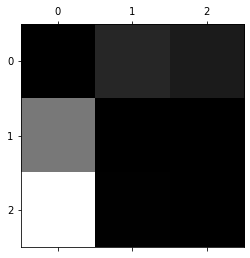

[[0.         0.02963041 0.02141729]
 [0.09305537 0.         0.00052611]
 [0.19720344 0.00098226 0.        ]]


In [16]:
show_confusion_matrix(sgd_clf)

The order is Galaxy, QSO, Stars so we notice that objects often get misclassified as galaxies, especially stars! However, galaxies most often get correclty classified (little errors on that row)

#### B. For SVC

C:\Users\ellio\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\ellio\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\ellio\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


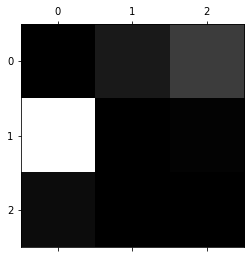

[[0.         0.00920291 0.02209119]
 [0.09344995 0.         0.00131527]
 [0.00439129 0.         0.        ]]


In [17]:
show_confusion_matrix(svm_clf)

QSO often misclassified as Galaxies and galaxies occasionally misclassified as stars. Stars always well classified.

#### C. Random Forest Classifier

C:\Users\ellio\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\ellio\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\ellio\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


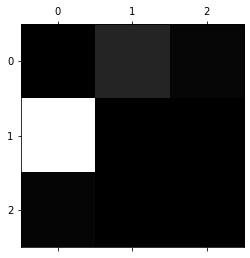

[[0.         0.01166684 0.00214805]
 [0.08148099 0.         0.00019729]
 [0.0017334  0.         0.        ]]


In [18]:
show_confusion_matrix(forest_clf)

#### D. K-Neighbors Classifier


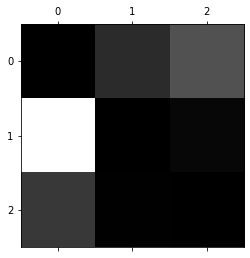

[[0.         0.01253027 0.0235864 ]
 [0.07385243 0.         0.0021702 ]
 [0.01617842 0.0002889  0.        ]]


In [19]:
show_confusion_matrix(knn_clf)

### Comparing Random Forest, SGD, KNN and SVC 

ROC curves not supported for multiclass classification. But from the accuracy calculations and confusion matrices, Random Forest seems to be the best model to use for this dataset.

--------------------------

## Accuracy on test set

In [ ]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.astype(np.float64))
# CAREFUL JUST TRANSFORM DON'T FIT
x_test_scaled = scaler.transform(x_test.astype(np.float64))

### 1. (BEST) Random Forest

In [14]:
forest_clf = RandomForestClassifier(random_state=42)

forest_clf.fit(x_train_scaled, y_train)
y_test_pred = forest_clf.predict(x_test_scaled)

# since we have label imbalance (much more galaxies -> use weighted average)
print("F1 score:", f1_score(y_test, y_test_pred, average="weighted"))

confusion_matrix(y_test, y_test_pred)

C:\Users\ellio\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


F1 score: 0.9776639441933226


array([[11825,   119,    15],
       [  304,  3451,     0],
       [    5,     0,  4281]], dtype=int64)

### 2. SVC

In [15]:
svm_clf = SVC()

svm_clf.fit(x_train_scaled, y_train)
y_test_pred = svm_clf.predict(x_test_scaled)

print("F1 score:", f1_score(y_test, y_test_pred, average="weighted"))

confusion_matrix(y_test, y_test_pred)

F1 score: 0.9644547202351432


array([[11617,   100,   242],
       [  338,  3406,    11],
       [   16,     0,  4270]], dtype=int64)

### 3. KNN

In [16]:
knn_clf = KNeighborsClassifier()

knn_clf.fit(x_train_scaled, y_train)
y_test_pred = knn_clf.predict(x_test_scaled)

print("F1 score:", f1_score(y_test, y_test_pred, average="weighted"))

confusion_matrix(y_test, y_test_pred)

F1 score: 0.9629697917717552


array([[11555,   124,   280],
       [  262,  3485,     8],
       [   66,     0,  4220]], dtype=int64)

### 4. (WORST) SGD

In [17]:
sgd_clf = SGDClassifier(random_state=42)

sgd_clf.fit(x_train_scaled, y_train)
y_test_pred = sgd_clf.predict(x_test_scaled)

print("F1 score:", f1_score(y_test, y_test_pred, average="weighted"))

confusion_matrix(y_test, y_test_pred)

F1 score: 0.9057778532215817


array([[11327,   344,   288],
       [  325,  3426,     4],
       [  899,     2,  3385]], dtype=int64)

### Fine-tuning the model using hyperparameters

In [18]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_clf = RandomForestClassifier()

grid_search = GridSearchCV(forest_clf, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(x_train, y_train)

ValueError: could not convert string to float: 'GALAXY'